# Initializing Colab

Installing pytorch_xla

In [ ]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

Downloading data

In [ ]:
!wget https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/prediction/v1.1/{sample.tar,aerial_map.tar,semantic_map.tar}
!wget https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/prediction/v1.1/{train.tar,validate.tar} 
!mkdir -p lyft/scenes/ lyft/aerial_map/ lyft/semantic_map/
!tar -xf sample.tar sample.zarr && mv sample.zarr lyft/scenes/ && rm sample.tar
!tar -xf aerial_map.tar -C lyft/ && rm aerial_map.tar
!tar -xf semantic_map.tar meta.json && mv meta.json lyft/
!tar -xf semantic_map.tar semantic_map.pb && mv semantic_map.pb lyft/semantic_map/ && rm semantic_map.tar

Cloning repository and installing dependencies

In [ ]:
!git clone https://github.com/VahidZee/ReasonAwareRasterizedTrajectoryPrediction.git
cd ReasonAwareRasterizedTrajectoryPrediction
pip install -r requirements.txt

# Importing dependencies

In [1]:
import pytorch_lightning as pl
from l5kit.configs import load_config_data
from raster import BaseResnet, BaseTrainerModule, LyftDataModule
import torch

## Initializing various parts

In [2]:
config = load_config_data('/Users/vahidzee/Desktop/EPFL/raster/raster-git/config.yaml')
datamodule = LyftDataModule('/Users/vahidzee/Desktop/lyft_data/', config)
training_procedure = BaseTrainerModule(config)
training_procedure.datamodule = datamodule

In [3]:
# from raster.utils import find_batch_extremes
datamodule.setup()
datamodule.batch_size= 23
batch = next(iter(datamodule.val_dataloader()))

In [4]:
loss, outputs = training_procedure(batch)

In [134]:
batch['target_positions'][10,20]

tensor([-22.1185, -37.9382])

In [19]:
find_batch_extremes(batch, loss, outputs)

12.6 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
import torch
import numpy as np
from l5kit.geometry import transform_points, transform_point
from l5kit.visualization.utils import ARROW_LENGTH_IN_PIXELS, ARROW_THICKNESS_IN_PIXELS, ARROW_TIP_LENGTH_IN_PIXELS
from l5kit.visualization import TARGET_POINTS_COLOR, draw_trajectory, PREDICTED_POINTS_COLOR


def _set_image_type(image: np.array):
    image_np = image
    float_image = np.zeros(image_np.shape)
    for i, channel in enumerate(image_np):
        for j, row in enumerate(channel):
            for z, pixel in enumerate(row):
                float_image[i][j][z] = float(pixel)
    return float_image


def draw_single_image(
        rasterizer,
        image,
        centroid,
        world_to_image,
        target_positions,
        target_yaws,
        predicted_positions=None,
        predicted_yaws=None,
        target_color=TARGET_POINTS_COLOR,
        predicted_color=PREDICTED_POINTS_COLOR,
) -> torch.Tensor:
    predicted_yaws = predicted_yaws or target_yaws
    im = _set_image_type(rasterizer.to_rgb(image.cpu().data.numpy().transpose(1, 2, 0)))
    draw_trajectory(im, transform_points(target_positions.cpu().data.numpy() + centroid[:2].cpu().data.numpy(), world_to_image.cpu().data.numpy()), target_yaws.cpu().data.numpy(), target_color)
    if predicted_positions is not None:
        draw_trajectory(im, transform_points(predicted_positions.cpu().data.numpy() + centroid[:2].cpu().data.numpy(), world_to_image.cpu().data.numpy()), predicted_yaws.cpu().data.numpy(),
                        predicted_color)
    return np.uint8(im[::-1])


In [23]:
output = torch.zeros(23,25,2)
output[:,:,0] = 0
output[:,:,1] = torch.arange(25, dtype=torch.float32)/1.5

In [5]:
target_positions_pixels = 
    transform_points(targets[0].detach().numpy() + batch["centroid"][0].detach().numpy()[:2],batch["world_to_image"][0].detach().numpy())

NameError: name 'transform_points' is not defined

In [35]:
from l5kit.geometry import transform_points
def batch_stats(batch):
    targets = batch["target_positions"]
    batch_size = targets
    for hist, future, cent, wti in zip(batch['history_positions'], batch["target_positions"], batch['centroid'], batch['world_to_image']):
        trajectory_stat(hist.cpu().data.numpy(), future.cpu().data.numpy(), cent.cpu().data.numpy(), wti.cpu().data.numpy())
#     return target_positions_pixels

In [36]:
def trajectory_stat(history_positions: np.array, target_positions: np.array, centroid: np.array, world_to_image: np.array):
    target_pixels = target_positions_pixels = transform_points(target_positions + centroid, world_to_image)
    print(target_pixels)

In [43]:
i = 8
hist = batch['history_positions'][i]
future = batch['target_positions'][i]
cent = batch['centroid'][i]
wti = batch['world_to_image'][i]
yaw = batch['target_yaws'][i]
im = batch['image']
trajectory_stat(hist.cpu().data.numpy(), future.cpu().data.numpy(), cent.cpu().data.numpy(), wti.cpu().data.numpy())

[[ 60.438423   111.83291379]
 [ 65.02122179 111.71603503]
 [ 69.26079458 111.62219815]
 [ 73.01773863 111.47636397]
 [ 76.6516741  111.49539474]
 [ 80.76449437 111.32234557]
 [ 85.16877217 111.30964728]
 [ 89.67104539 111.16113313]
 [ 94.18392562 111.00228786]
 [ 97.62397491 110.99750814]
 [101.10235396 111.04217544]
 [104.82634591 111.18837088]
 [108.65080458 111.26293845]
 [112.66893388 111.3202635 ]
 [116.75680475 111.38999542]
 [120.86866676 111.47383574]
 [125.56689311 111.64518652]
 [130.29813147 111.80663663]
 [135.00345744 111.93316425]
 [139.6148277  112.03162932]
 [144.2178203  111.95169145]
 [148.53480715 112.05179002]
 [152.85086487 112.04654835]
 [157.19170025 112.10898261]
 [161.51428997 112.17258271]]


In [46]:
from raster.utils import draw_single_image, draw_batch

In [48]:
draw_single_image(datamodule.train_data.rasterizer,im, cent, wti, future, yaw )

ValueError: axes don't match array

In [47]:
draw_batch(batch)

TypeError: draw_batch() missing 1 required positional argument: 'batch'

In [10]:
batch["centroid"]

tensor([[  671.7809, -2196.8337],
        [  672.2151, -2196.1038],
        [  672.6445, -2195.3599],
        [  673.0810, -2194.6311],
        [  673.4843, -2193.8835],
        [  716.4702, -2119.2139],
        [  715.2706, -2121.1035],
        [  714.0636, -2122.9897],
        [  712.7855, -2124.9258],
        [  711.5886, -2126.7964],
        [  710.3766, -2128.7419],
        [  727.2925, -2113.1047],
        [  727.9191, -2112.1262],
        [  728.5948, -2111.1726],
        [  729.2447, -2110.2017],
        [  729.9147, -2109.2456],
        [  730.5786, -2108.2559],
        [  731.2435, -2107.2839],
        [  731.8946, -2106.3264],
        [  842.1107, -1947.3430],
        [  842.2941, -1947.1161],
        [  842.4614, -1946.8530],
        [  842.6262, -1946.6150]], dtype=torch.float64)

In [171]:
result = draw_batch(datamodule.train_data.rasterizer, batch)

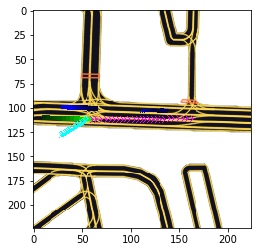

In [170]:
plt.imshow(result[5])

AttributeError: module 'matplotlib.pyplot' has no attribute 'clear'

In [26]:
import matplotlib.pyplot as plt

In [ ]:
draw_single_image(datamodule.train_data.rasterizer, )

In [3]:
checkpointing = pl.callbacks.ModelCheckpoint()

In [4]:
trainer = pl.Trainer(fast_dev_run=True)

Running in fast_dev_run mode: will run a full train, val and test loop using a single batch
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [5]:
trainer.fit(training_procedure)


  | Name      | Type       | Params
-----------------------------------------
0 | model     | BaseResnet | 23 M  
1 | criterion | MSELoss    | 0     
/Users/vahidzee/opt/miniconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/vahidzee/opt/miniconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


16


AttributeError: 'NoneType' object has no attribute 'callback_metrics'

In [ ]:
shit = training_procedure.asghar

In [18]:
shit['image'].shape

torch.Size([2, 16, 25, 2, 25, 224, 224])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=lightning_logs

In [11]:
trainer.save_checkpoint('shit')

In [15]:
pl.Trainer(resume_from_checkpoint='shit')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


TypeError: fit() missing 1 required positional argument: 'model'